In [2]:
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt
import pickle

import numpy as np
from scipy.optimize import nnls
from numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


Current data is shaped: (1250, 100, 514)


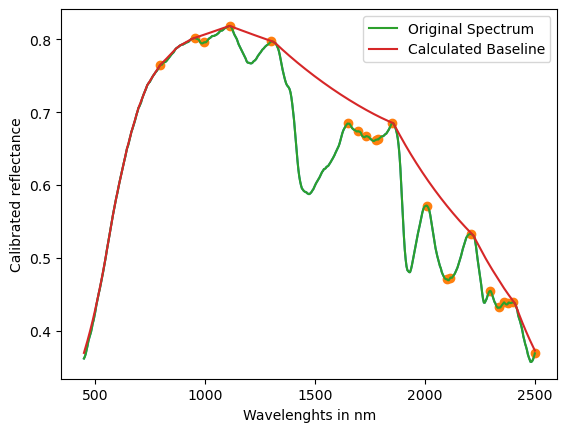

In [3]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 25
curr_y = 50

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

# Invert the data 
pix_inverse = 1 / curr_pixel 

baseline_fitter = Baseline(wav_array,
                           check_finite=False)

# Calculate the baseline
baseline_inv = baseline_fitter.snip(pix_inverse,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0)[0]

# Invert the result
curr_baseline = 1 / baseline_inv         

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
plt.legend()



In [4]:
# open a file, where you stored the pickled data
file = open('baseline_hybrid_corrected_array.pickle', 'rb')

# dump information to that file
baseline_corrected_data = pickle.load(file)

# close the file
file.close()

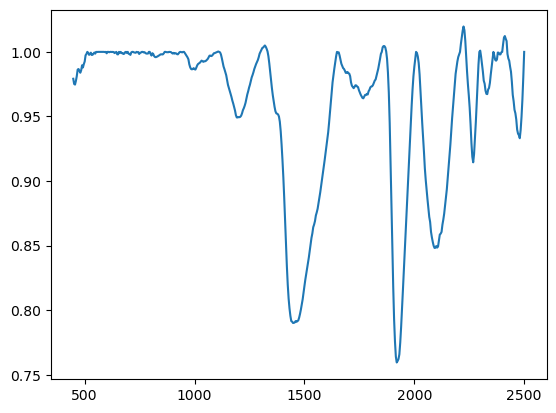

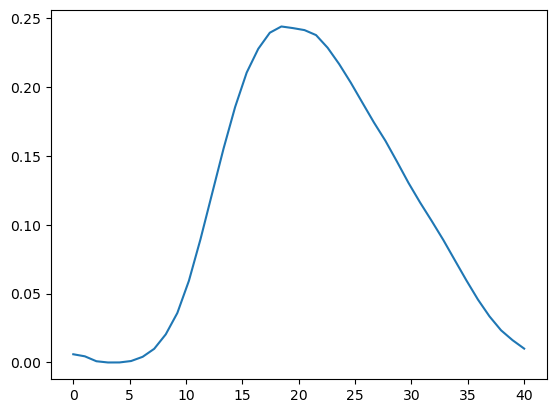

In [5]:
# Try fitting EGO gaussian to a specific peak

curr_spectrum = baseline_corrected_data[25,50,:]

plt.plot(wav_array, curr_spectrum)


curr_start = 350
curr_end = 390
curr_peak = (curr_spectrum[curr_start:curr_end])
# Normalize the current peak
curr_peak = curr_peak / curr_peak.max()
curr_peak = 1 - curr_peak
curr_wavs = wav_array[curr_start:curr_end]
plt.figure()
plt.plot(np.linspace(0, curr_peak.shape[0], curr_peak.shape[0]),
          curr_peak)



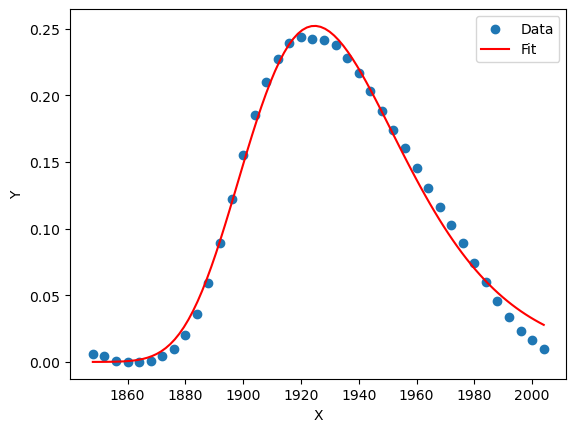

In [6]:
def compute_EGO_Gaussian(params, lmbda):
    # EGO Gaussian function 
    si, mu_i, sigma_i, k_i = params
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))


# Initial guess for the parameters
initial_guess = [1, # Amplitude
                 np.mean(curr_wavs), # Position
                 np.std(curr_wavs), # Width
                 0.9] # Asymmetry]

# Perform the curve fit
params, params_covariance = curve_fit(compute_EGO_Gaussian,
                                      curr_wavs,
                                      curr_peak,
                                      p0=initial_guess,
                                      )

# Extract the fitted parameters
si_fit, mu_i_fit, sigma_i_fit, k_i_fit = params

# Generate the x-values for plotting
x_values = np.linspace(min(curr_wavs), max(curr_wavs), 100)

# Generate the y-values using the fitted parameters
y_values = compute_EGO_Gaussian(x_values, si_fit, mu_i_fit, sigma_i_fit, k_i_fit)

# Plot the original data and the fitted curve
plt.scatter(curr_wavs, curr_peak, label='Data')
plt.plot(x_values, y_values, 'r-', label='Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [40]:
# def EGO(lmbda, s, t, mu, sigma, k):
#     return -(s / (1 - np.exp(-0.5 * t))) * (1 - np.exp(-0.5 * t * np.exp(-0.5 * ((lmbda - mu) / (sigma + k * (lmbda - mu)))**2)))


# # Initial guess for the parameters
# initial_guess = [1, # Amplitude
#                  np.mean(curr_wavs), # Position
#                  np.std(curr_wavs), # Width
#                  0.9,# Asymmetry
#                  1] # flattened]

# # Perform the curve fit
# params, params_covariance = curve_fit(EGO,
#                                       curr_wavs,
#                                       curr_peak,
#                                       p0=initial_guess,
#                                       )

# # Extract the fitted parameters
# si_fit, mu_i_fit, sigma_i_fit, k_i_fit, t_fit = params

# # Generate the x-values for plotting
# x_values = np.linspace(min(curr_wavs), max(curr_wavs), 100)

# # Generate the y-values using the fitted parameters
# y_values = EGO(x_values, si_fit, mu_i_fit, sigma_i_fit, k_i_fit, t_fit)

# # Plot the original data and the fitted curve
# plt.scatter(curr_wavs, curr_peak, label='Data')
# plt.plot(x_values, y_values, 'r-', label='Fit')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.show()

In [8]:
def gaussian(x, amplitude, center, stddev):
    return amplitude * np.exp(-0.5 * ((x - center) / stddev) ** 2)

def lorentzian(x, amplitude, center, gamma):
    return (amplitude * (gamma**2)) / ((x - center)**2 + gamma**2)

def asymmetric_gaussian(x, amplitude_left, amplitude_right, center, stddev_left, stddev_right):
    return np.where(x < center, amplitude_left * np.exp(-0.5 * ((x - center) / stddev_left) ** 2),
                    amplitude_right * np.exp(-0.5 * ((x - center) / stddev_right) ** 2))

def calculate_r_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2




In [9]:
# Fit the EGO Gaussian function
params_ego, _ = curve_fit(compute_EGO_Gaussian,
                          curr_wavs,
                          curr_peak,
                          p0=initial_guess)
y_pred_ego = compute_EGO_Gaussian(curr_wavs, *params_ego)
r2_ego = calculate_r_squared(curr_peak, y_pred_ego)

# Fit the Gaussian function
params_gaussian, _ = curve_fit(gaussian,
                               curr_wavs,
                               curr_peak,
                              p0=[1, np.median(curr_wavs), np.std(curr_wavs)])
y_pred_gaussian = gaussian(curr_wavs, *params_gaussian)
r2_gaussian = calculate_r_squared(curr_peak, y_pred_gaussian)

# Fit the Lorentzian function
params_lorentzian, _ = curve_fit(lorentzian,
                                 curr_wavs,
                                 curr_peak,
                                p0=[1, np.median(curr_wavs), 100])
y_pred_lorentzian = lorentzian(curr_wavs, *params_lorentzian)
r2_lorentzian = calculate_r_squared(curr_peak, y_pred_lorentzian)

# Fit the Asymmetric Gaussian function
params_asymmetric_gaussian, _ = curve_fit(asymmetric_gaussian,
                                          curr_wavs,
                                          curr_peak,
                                         p0=[1,
                                             1,
                                             np.mean(curr_wavs),
                                             np.std(curr_wavs),
                                             np.std(curr_wavs)])
y_pred_asymmetric_gaussian = asymmetric_gaussian(curr_wavs, *params_asymmetric_gaussian)
r2_asymmetric_gaussian = calculate_r_squared(curr_peak, y_pred_asymmetric_gaussian)

# Generate x-values for plotting
x_values = np.linspace(min(curr_wavs), max(curr_wavs), 100)

# Generate y-values for each function using the fitted parameters
y_values_ego = compute_EGO_Gaussian(x_values, *params_ego)
y_values_gaussian = gaussian(x_values, *params_gaussian)
y_values_lorentzian = lorentzian(x_values, *params_lorentzian)
y_values_asymmetric_gaussian = asymmetric_gaussian(x_values, *params_asymmetric_gaussian)


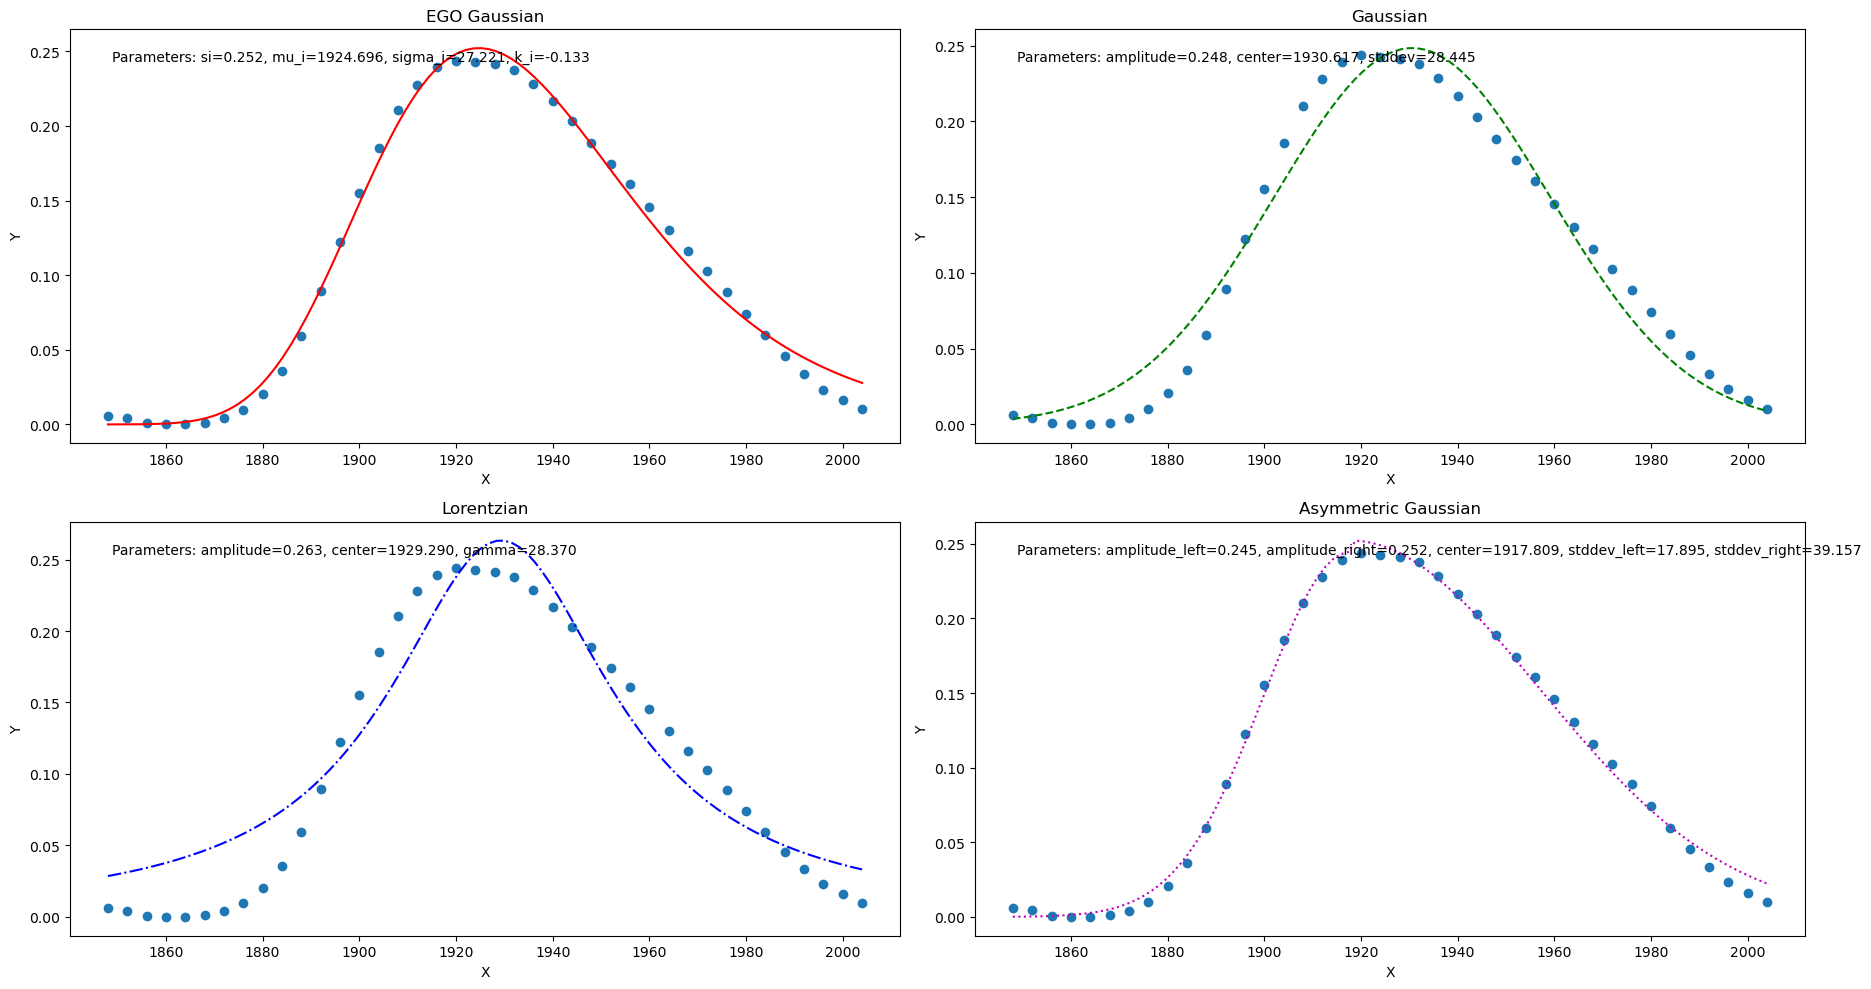

In [10]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Plot the original data and the fitted curves in subplots
axs[0, 0].scatter(curr_wavs, curr_peak, label='Data')
axs[0, 0].plot(x_values, y_values_ego, 'r-', label=f'EGO Gaussian (R-squared: {r2_ego:.3f})')
axs[0, 0].set_title('EGO Gaussian')
axs[0, 0].text(0.05, 0.95, f"Parameters: si={params_ego[0]:.3f}, mu_i={params_ego[1]:.3f}, sigma_i={params_ego[2]:.3f}, k_i={params_ego[3]:.3f}",
               transform=axs[0, 0].transAxes, verticalalignment='top')

axs[0, 1].scatter(curr_wavs, curr_peak, label='Data')
axs[0, 1].plot(x_values, y_values_gaussian, 'g--', label=f'Gaussian (R-squared: {r2_gaussian:.3f})')
axs[0, 1].set_title('Gaussian')
axs[0, 1].text(0.05, 0.95, f"Parameters: amplitude={params_gaussian[0]:.3f}, center={params_gaussian[1]:.3f}, stddev={params_gaussian[2]:.3f}",
               transform=axs[0, 1].transAxes, verticalalignment='top')

axs[1, 0].scatter(curr_wavs, curr_peak, label='Data')
axs[1, 0].plot(x_values, y_values_lorentzian, 'b-.', label=f'Lorentzian (R-squared: {r2_lorentzian:.3f})')
axs[1, 0].set_title('Lorentzian')
axs[1, 0].text(0.05, 0.95, f"Parameters: amplitude={params_lorentzian[0]:.3f}, center={params_lorentzian[1]:.3f}, gamma={params_lorentzian[2]:.3f}",
               transform=axs[1, 0].transAxes, verticalalignment='top')

axs[1, 1].scatter(curr_wavs, curr_peak, label='Data')
axs[1, 1].plot(x_values, y_values_asymmetric_gaussian, 'm:', label=f'Asymmetric Gaussian (R-squared: {r2_asymmetric_gaussian:.3f})')
axs[1, 1].set_title('Asymmetric Gaussian')
axs[1, 1].text(0.05, 0.95, f"Parameters: amplitude_left={params_asymmetric_gaussian[0]:.3f}, amplitude_right={params_asymmetric_gaussian[1]:.3f}, "
                             f"center={params_asymmetric_gaussian[2]:.3f}, stddev_left={params_asymmetric_gaussian[3]:.3f}, "
                             f"stddev_right={params_asymmetric_gaussian[4]:.3f}",
               transform=axs[1, 1].transAxes, verticalalignment='top')

# Set common x and y labels for all subplots
for ax in axs.flat:
    ax.set(xlabel='X', ylabel='Y')

# Adjust spacing between subplots
fig.tight_layout()

# Show the subplots
plt.show()


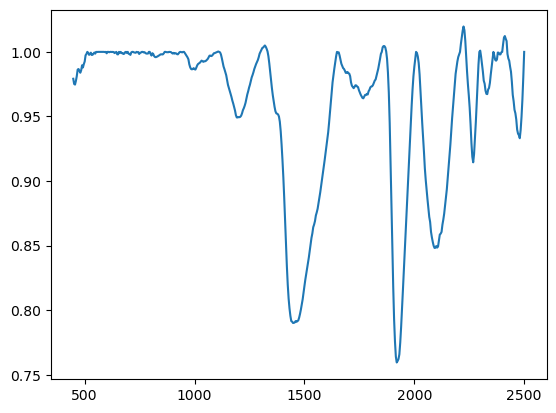

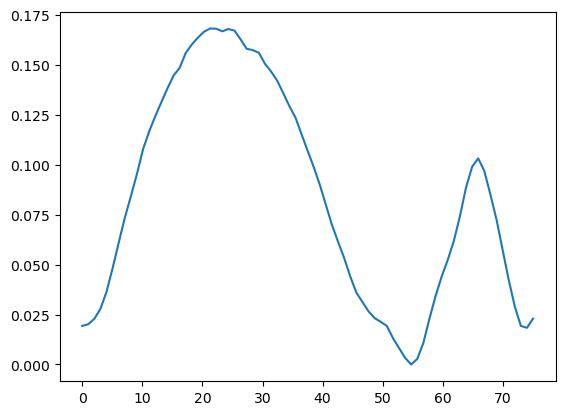

In [137]:
# Try fitting EGO gaussian to a specific peak

curr_spectrum = baseline_corrected_data[25,50,:]

plt.plot(wav_array, curr_spectrum)


curr_start = 390
curr_end = 465
curr_peak =curr_spectrum[curr_start:curr_end]
# Normalize the current peak
curr_peak = curr_peak / curr_peak.max()
curr_peak = 1 - curr_peak
curr_wavs = wav_array[curr_start:curr_end]
plt.figure()
plt.plot(np.linspace(0, curr_peak.shape[0], curr_peak.shape[0]),
          curr_peak)


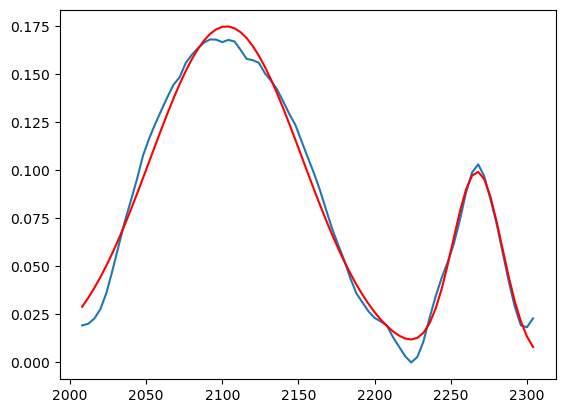

In [138]:
def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

guess = [2100, 1, 10, 
         2275, 1, 10]
# for i in range(12):
#     guess += [60+80*i, 46000, 25]

popt, pcov = curve_fit(func, curr_wavs, curr_peak, p0=guess)
fit = func(curr_wavs, *popt)

plt.plot(curr_wavs, curr_peak)
plt.plot(curr_wavs, fit , 'r-')
plt.show()

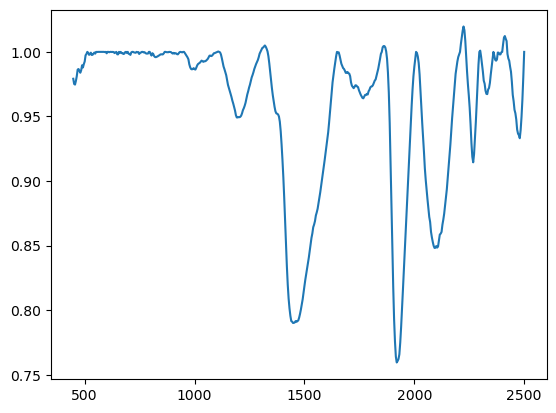

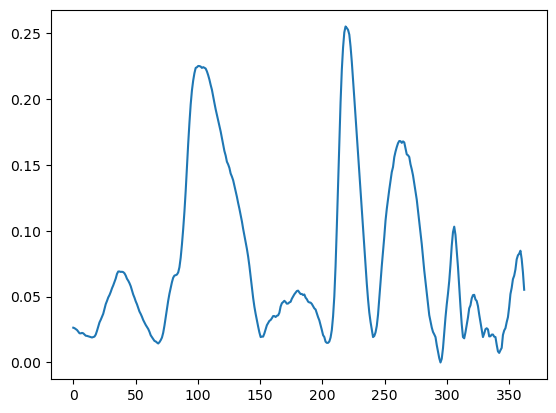

In [13]:
# Try fitting EGO gaussian to a specific peak

curr_spectrum = baseline_corrected_data[25,50,:]

plt.plot(wav_array, curr_spectrum)


curr_start = 150
curr_end = 512
curr_peak = (curr_spectrum[curr_start:curr_end])
# Normalize the current peak
curr_peak = curr_peak / curr_peak.max()
curr_peak = 1 - curr_peak

curr_wavs = wav_array[curr_start:curr_end]
plt.figure()
plt.plot(np.linspace(0, curr_peak.shape[0], curr_peak.shape[0]),
          curr_peak)

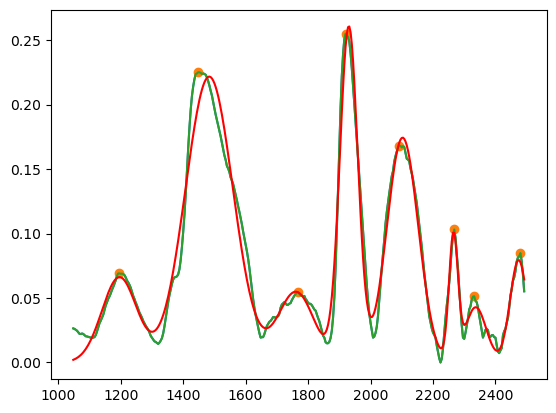

In [14]:
def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

test_peaks = find_peaks(curr_peak, width=5)[0]
plt.plot(curr_wavs, curr_peak)
plt.plot(curr_wavs[test_peaks], curr_peak[test_peaks], 'o')

guess = []
for p in test_peaks:
    guess.append(np.round(curr_wavs[p]))
    guess.append(curr_peak[p])
    guess.append(10)


# guess = [2100, 1, 10, 
#          2275, 1, 10]
# # for i in range(12):
# #     guess += [60+80*i, 46000, 25]

popt, pcov = curve_fit(func, curr_wavs, curr_peak, p0=guess)
fit = func(curr_wavs, *popt)

plt.plot(curr_wavs, curr_peak)
plt.plot(curr_wavs, fit , 'r-')
plt.show()

In [121]:
# popt.shape



(21,)

/tmp/ipykernel_13038/2299751110.py:9: RuntimeWarning: divide by zero encountered in divide
  y = y + (si * np.exp(-0.5 * ((x - mu_i) ** 2 / (sigma_i - k_i * (x - mu_i)) ** 2)))


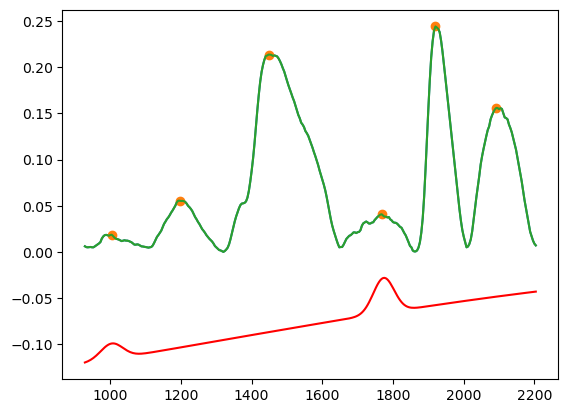

In [178]:
def ego_sum(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 4):
        mu_i = params[i]
        si = params[i+1]
        sigma_i = params[i+2]
        k_i = params[i+3]
        
        y = y + (si * np.exp(-0.5 * ((x - mu_i) ** 2 / (sigma_i - k_i * (x - mu_i)) ** 2)))
        
    return y

test_peaks = find_peaks(curr_peak, width=5)[0]
plt.plot(curr_wavs, curr_peak)
plt.plot(curr_wavs[test_peaks], curr_peak[test_peaks], 'o')



guess = []
for p in test_peaks:
    guess.append(np.round(curr_wavs[p]))
    guess.append(curr_peak[p])
    guess.append(10)
    guess.append(-0.01)


popt, pcov = curve_fit(ego_sum, curr_wavs, curr_peak, p0=guess)
fit = func(curr_wavs, *popt)

plt.plot(curr_wavs, curr_peak)
plt.plot(curr_wavs, fit , 'r-')
plt.show()

/tmp/ipykernel_12099/2812709912.py:8: RuntimeWarning: divide by zero encountered in divide
  return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))


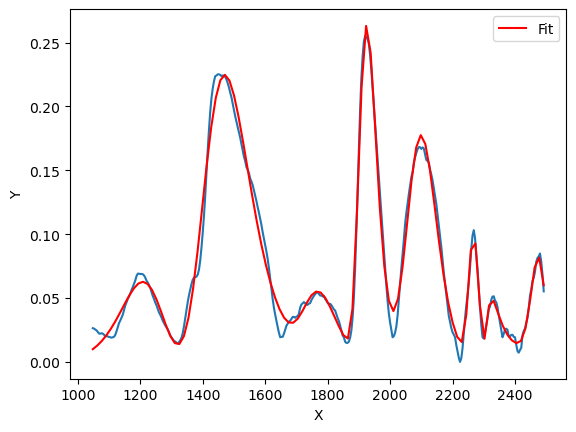

In [15]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from scipy.signal import find_peaks

def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

def weighted_sum_EGO_Gaussians(x, *params):
    num_peaks = len(params) // 4
    result = np.zeros_like(x)
    for i in range(num_peaks):
        si, mu_i, sigma_i, k_i = params[i*4 : (i+1)*4]
        result += compute_EGO_Gaussian(x, si, mu_i, sigma_i, k_i)
    return result

def find_initial_guess(x, y):
    peaks, _ = find_peaks(y, width=5)
    initial_guess = []
    for p in peaks:
        initial_guess += [1.0, x[p], 10, -0.1]
    return initial_guess

# Find initial guess for the parameters
initial_guess = find_initial_guess(curr_wavs, curr_peak)

# Fit the weighted sum of EGO Gaussians to the data
params, _ = curve_fit(weighted_sum_EGO_Gaussians,
                      curr_wavs,
                      curr_peak,
                      p0=initial_guess)

# Generate x-values for plotting the fitted curve
x_values = np.linspace(min(curr_wavs), max(curr_wavs), 100)

# Generate y-values for the fitted curve using the obtained parameters
y_values = weighted_sum_EGO_Gaussians(x_values, *params)

# Plot the original data and the fitted curve
plt.plot(curr_wavs, curr_peak)
plt.plot(x_values, y_values, 'r-', label='Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [36]:
# integration to get the area of the fit
import scipy.integrate as integrate
# # integrate.quad(weighted_sum_EGO_Gaussians(x_values, *params), x_values[0], x_values[-1])
# # integrate.quad(weighted_sum_EGO_Gaussians, x_values[0], x_values[-1], args=(*params)) 


# import numpy as np
# from scipy.integrate import trapz

# # # Generate x-values and y-values for the fitted curve
# # x_values = np.linspace(min(curr_wavs), max(curr_wavs), 100)
# y_values = weighted_sum_EGO_Gaussians(x_values, *params)

# # Calculate the integral using the trapezoidal rule
# integral = trapz(y_values, x_values)

# integral

# Okay restart - in order to do this for the fitting Cari needs, we need to do it *by peak* in order
# to calculate depth^2 / peak


def calc_sum_EGO_Gaussians_auc_features(x, *params):
    num_peaks = len(params) // 4
    integral_list = []
    crystallinity_list = []
    
    for i in range(num_peaks):
        si, mu_i, sigma_i, k_i = params[i*4 : (i+1)*4]
        curr_y_vals = compute_EGO_Gaussian(x, si, mu_i, sigma_i, k_i)
        curr_integral = trapz(curr_y_vals, x)
        integral_list.append(curr_integral)
        crystallinity_list.append(si**2 / curr_integral)
    return integral_list, crystallinity_list


auc_by_peak, crystallinity_by_peak = calc_sum_EGO_Gaussians_auc_features(x_values, *params)

auc_by_peak
crystallinity_by_peak

[0.00038023846950428303,
 0.0011640961432442312,
 0.000377778675806643,
 0.0035380948758580825,
 0.00148053191909239,
 0.0024940416524034184,
 0.0005667483691918815,
 0.00170192696554342]